# Agglomerative Hierarchical clustersing (AHC)
This implementation follows the base AHC algorithm implementation using destance matrix.<br>
## Experimental setup & some notes 
So here we basically implement the basic algorithm of AHC
**note**: we try to match the same behaviour as SK-learn, however, SK assume different labels as this will only affect the percentage_similarity which is not a metric.<br>
Also, SK return dataset labels without dendrogram so we won't implement this part as it's not needed
** This notebook has the following **<br>
1- *Utility section*:Some untility functions for printing results and stuff<br>
2- *basic AHC implementation with some comments*<br>
3- *results per dataset*: overall results for each dataset + some commments<br>
........................ Thank you .................................

In [17]:
from sklearn import datasets
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import os
import seaborn as sns
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score, calinski_harabasz_score, davies_bouldin_score, mutual_info_score
from sklearn.preprocessing import StandardScaler
import time
from sklearn.decomposition import PCA
import kagglehub
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

### utility functions

In [18]:
"""
This function is used to print the different matrics given the true labels and predicted labels.
"""
def print_metrics(X, true_labels_values, predicted_labels, print_res = True):
    if not print_res:
        return {
        "Silhouette": silhouette_score(X, predicted_labels),
        "Adjusted Rand": adjusted_rand_score(true_labels, predicted_labels),
        "Calinski-Harabasz": calinski_harabasz_score(X, predicted_labels),
        "Davies-Bouldin": davies_bouldin_score(X, predicted_labels),
        "Mutual Information": mutual_info_score(true_labels, predicted_labels)
        }
    print("-------------------------------------------------------------------")
    true_labels = LabelEncoder().fit_transform(true_labels_values)
    # Silhouette Score
    try:
        print(f"Silhouette score: {silhouette_score(X, predicted_labels):.4f}")
    except Exception as e:
        print(f"Silhouette score failed: {str(e)}")

    # Adjusted Rand Score
    try:
        print(f"Adjusted Rand score: {adjusted_rand_score(true_labels, predicted_labels):.4f}")
    except Exception as e:
        print(f"Adjusted Rand score failed: {str(e)}")

    # Calinski-Harabasz Score
    try:
        print(f"Calinski-Harabasz score: {calinski_harabasz_score(X, predicted_labels):.4f}")
    except Exception as e:
        print(f"Calinski-Harabasz score failed: {str(e)}")

    # Davies-Bouldin Score
    try:
        print(f"Davies-Bouldin score: {davies_bouldin_score(X, predicted_labels):.4f}")
    except Exception as e:
        print(f"Davies-Bouldin score failed: {str(e)}")

    # Mutual Information Score
    try:
        print(f"Mutual Information score: {mutual_info_score(true_labels, predicted_labels):.4f}")
    except Exception as e:
        print(f"Mutual Information score failed: {str(e)}")

In [19]:
def percentage_similarity(base_array, sklearn_array):
    # Ensure both arrays have the same shape
    if base_array.shape != sklearn_array.shape:
        raise ValueError("Input arrays must have the same shape")
    cnt_sim = 0
    for i,x in enumerate(base_array):
      if x == sklearn_array[i]:
        cnt_sim += 1
    return cnt_sim * 100/ len(base_array)


In [20]:
# supporting parameters in AHC
linkage = 'single'
distance = lambda x,y: np.linalg.norm(x-y) #Euclidean distance

### AHC Base Implementaion

In [ ]:
''' 
@function: base_ahc
    @param: X: input data
            n_clusters: number of clusters
            linkage: linkage method
            distance: distance metric
    @note: This function implements the base Agglomerative Hierarchical Clustering algorithm
            Taking number of clusters as stopping criteria as this is more convenient for the our compartive study with sklearn
            implemntation.
            ** input must be a pandas dataframe
    @return: dendrogram
'''
def base_ahc(X, n_clusters, linkage, distance):
    #ensure X is a numpy array
    X = np.array(X)
    #step:1 calculate the distance matrix
    n = X.shape[0] # number of data points
    #initialize the distance matrix with inf
    distance_matrix = np.full((n,n),np.inf)
    for i in range(n):
        for j in range(i,n):
            if i == j:
                distance_matrix[i,j] = 0 #fill diagonal with 0
            else:
                distance_matrix[i,j] = distance(X[i], X[j])
    #step:2 initialize clusters
    clusters = [[i] for i in range(n)]
    #step:3 merge clusters
    while len(clusters) > n_clusters:
        #find the closest clusters using linkage method
        min_distance = np.inf
        for i in range(len(clusters)):
            for j in range(i+1, len(clusters)):
                #using single linkage
                if linkage == 'single':
                    cluster_distance = np.inf
                    for k in clusters[i]:
                        for l in clusters[j]:
                            if cluster_distance >= distance_matrix[k,l]:
                                cluster_distance = distance_matrix[k,l] 
                else:
                    Exception("Linkage method not implemented")
                if cluster_distance < min_distance:
                    min_distance = cluster_distance
                    min_i = i
                    min_j = j
        #merge the clusters
        clusters[min_i] += clusters[min_j]
        clusters.pop(min_j)
    #build and retrun the clusters label for each data point
    cluster_labels = np.zeros(n,dtype=np.int8)
    for i in range(len(clusters)):
        for j in clusters[i]:
            cluster_labels[j] = i
    return cluster_labels

### Comparison running section (Dataset-based)
To see justification and why those feature is encoded or either selected please refere to the paper and comparison.ipynb

#### Iris Dataset

In [ ]:
# default AHC Hyperparameters
BRANCH_FACTOR = 10
THRESHOLD = 0.5
IRIS_N_CLUSTERS = 3
path = kagglehub.dataset_download("himanshunakrani/iris-dataset")
iris = pd.read_csv(os.path.join(path, "iris.csv"))
iris = iris.dropna()

iris_filtered = iris.select_dtypes(include=['float64'])

X_iris = iris_filtered.to_numpy()

####################### Base AHC #######################
start_time = time.time()
labels_base_iris = base_ahc(X_iris, IRIS_N_CLUSTERS, linkage, distance)
# print(labels_base_iris)
print(f"Execution time (base): {time.time() - start_time} seconds")
print_metrics(X_iris, iris['species'], labels_base_iris)

############################ sklearn AHC #######################
sklearn_ahc = AgglomerativeClustering(n_clusters=IRIS_N_CLUSTERS, linkage=linkage, metric='euclidean')
start_time = time.time()
labels_sklearn_iris = sklearn_ahc.fit_predict(X_iris)
# print(labels_sklearn_iris)

print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
print_metrics(X_iris, iris['species'], labels_sklearn_iris)

Execution time (base): 0.44387245178222656 seconds
-------------------------------------------------------------------
Silhouette score: 0.3187
Adjusted Rand score: 0.5657
Calinski-Harabasz score: 253.6586
Davies-Bouldin score: 0.6038
Mutual Information score: 0.6412

Execution time (sklearn): 0.007008075714111328 seconds
-------------------------------------------------------------------
Silhouette score: 0.5118
Adjusted Rand score: 0.5638
Calinski-Harabasz score: 277.4927
Davies-Bouldin score: 0.4474
Mutual Information score: 0.6459
percentage_similarity: 0.0%


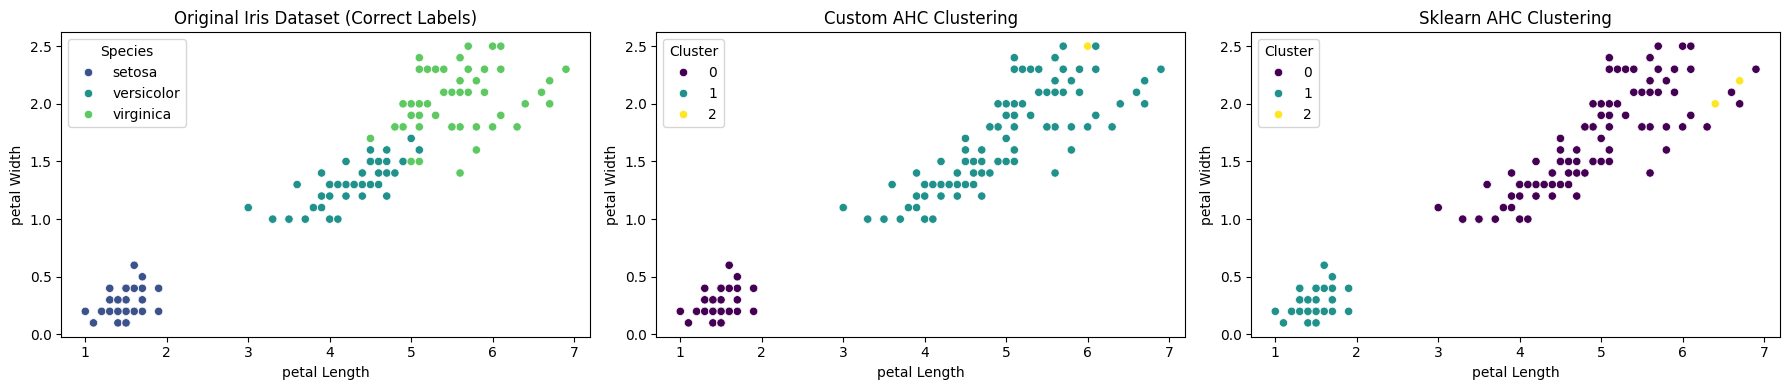

In [23]:

# Create a figure with three subplots
clusters_colors = "viridis"
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=iris, x="petal_length", y="petal_width", hue="species", palette=clusters_colors, ax=axes[0])
axes[0].set_title("Original Iris Dataset (Correct Labels)")
axes[0].set_xlabel("petal Length")
axes[0].set_ylabel("petal Width")
axes[0].legend(title="Species")

# Plot 2: Custom AHC Labels (labels_base_iris)
sns.scatterplot(data=iris, x="petal_length", y="petal_width", hue=labels_base_iris, palette=clusters_colors, ax=axes[1])
axes[1].set_title("Custom AHC Clustering")
axes[1].set_xlabel("petal Length")
axes[1].set_ylabel("petal Width")
axes[1].legend(title="Cluster")

# Plot 3: Sklearn AHC Labels (labels_sklearn_iris)
sns.scatterplot(data=iris, x="petal_length", y="petal_width", hue=labels_sklearn_iris, palette=clusters_colors, ax=axes[2])
axes[2].set_title("Sklearn AHC Clustering")
axes[2].set_xlabel("petal Length")
axes[2].set_ylabel("petal Width")
axes[2].legend(title="Cluster")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

0, 1 , 2 >> represents clusters that can me mapped again to the original classes for Iris dataset. but no need to do this since we just care about clustering quality.

### AI Dataset


In [32]:
AI_N_CLUSTERS = 3
from sklearn.preprocessing import OrdinalEncoder

path = kagglehub.dataset_download("katerynameleshenko/ai-index")
ai = pd.read_csv(os.path.join(path, "AI_index_db.csv"))
ai = ai.dropna()

ai["Total_score_Category"] = pd.cut(
    ai["Total score"],
    bins=[-float("inf"), 17.03, 26.91, float("inf")],
    labels=["Low", "Medium", "High"]
)
ai = ai.drop(columns=["Total score", "Country"])

ai_filtered = ai.drop(columns=["Total_score_Category"])

encoder = OrdinalEncoder()

categorical_cols = [col for col in ai_filtered.columns if ai_filtered[col].dtype not in [np.int64, np.float64]]
ai_filtered[categorical_cols] = encoder.fit_transform(ai_filtered[categorical_cols])

X_ai = ai_filtered.to_numpy()

print("AI Global Index")
print("####################### Base AHC #######################")
start_time = time.time()
labels_base_ai = base_ahc(X_ai, AI_N_CLUSTERS, linkage, distance)

print(f"Execution time (base): {time.time() - start_time} seconds")
print_metrics(X_ai, ai['Total_score_Category'], labels_base_ai)
#print(labels_base_ai)
print('############################ sklearn AHC #######################')
start_time = time.time()
sklearn_ahc = AgglomerativeClustering(n_clusters=AI_N_CLUSTERS, linkage=linkage, metric='euclidean')
labels_sklearn_ai = sklearn_ahc.fit_predict(X_ai)

print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
print_metrics(X_ai, ai['Total_score_Category'], labels_sklearn_ai)
#print(labels_sklearn_ai)

AI Global Index
####################### Base AHC #######################
Execution time (base): 0.06374382972717285 seconds
-------------------------------------------------------------------
Silhouette score: 0.4861
Adjusted Rand score: 0.0001
Calinski-Harabasz score: 11.4360
Davies-Bouldin score: 0.3093
Mutual Information score: 0.0360
############################ sklearn AHC #######################

Execution time (sklearn): 0.010052919387817383 seconds
-------------------------------------------------------------------
Silhouette score: 0.4861
Adjusted Rand score: 0.0001
Calinski-Harabasz score: 11.4360
Davies-Bouldin score: 0.3093
Mutual Information score: 0.0360


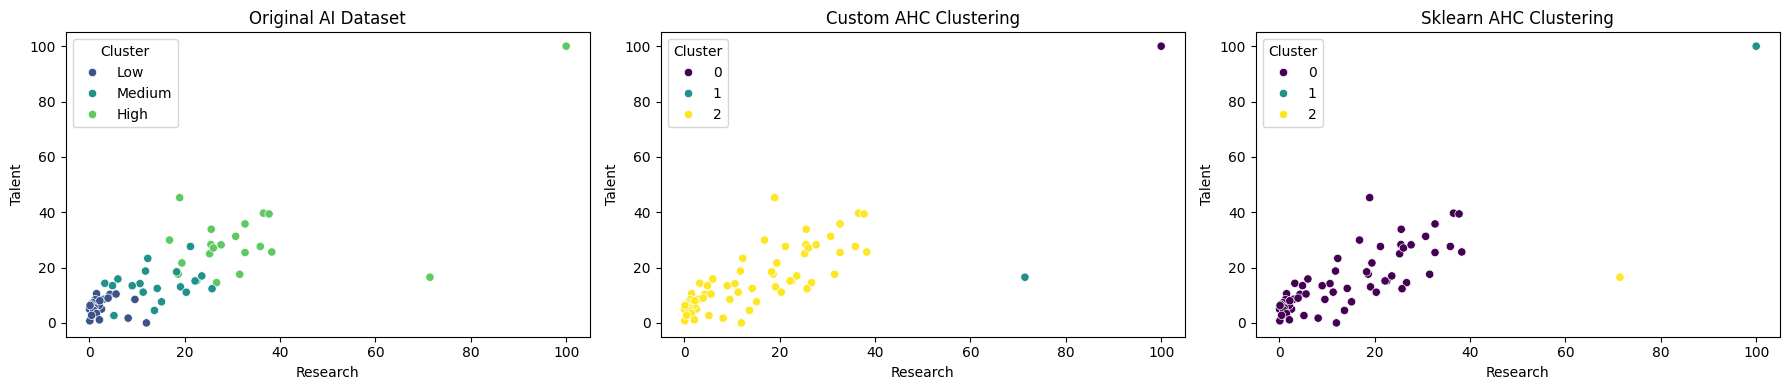

In [25]:
# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=ai, x="Research", y="Talent", hue="Total_score_Category", palette="viridis", ax=axes[0])
axes[0].set_title("Original AI Dataset")
axes[0].set_xlabel("Research")
axes[0].set_ylabel("Talent")
axes[0].legend(title="Cluster")

# Plot 2: Custom AHC Labels (labels_base_ai)
sns.scatterplot(data=ai, x="Research", y="Talent", hue=labels_base_ai, palette="viridis", ax=axes[1])
axes[1].set_title("Custom AHC Clustering")
axes[1].set_xlabel("Research")
axes[1].set_ylabel("Talent")
axes[1].legend(title="Cluster")

# Plot 3: Sklearn AHC Labels (labels_sklearn_ai)
sns.scatterplot(data=ai, x="Research", y="Talent", hue=labels_sklearn_ai, palette="viridis", ax=axes[2])
axes[2].set_title("Sklearn AHC Clustering")
axes[2].set_xlabel("Research")
axes[2].set_ylabel("Talent")
axes[2].legend(title="Cluster")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

0, 1 , 2 >> represents clusters that can me mapped again to the original classes for Iris dataset. but no need to do this since we just care about clustering quality.

## Earthquakes Dataset

In [29]:
EARTHQUACKE_N_CLUSTERS = 4
path = kagglehub.dataset_download("shreyasur965/recent-earthquakes")
earthquakes = pd.read_csv(os.path.join(path, "earthquakes.csv"))

earthquakes = earthquakes.drop(columns=["id", "type", "title", "date", "time", "updated", "url",
                                        "detailUrl", "status", "net", "code", "ids", "sources",
                                        "types", "geometryType", "place", "placeOnly", "location", "subnational", "city",
                                        "locality", "postcode", "what3words", "timezone", "locationDetails", "continent", "country"])

earthquakes = earthquakes.dropna()
earthquakes_filtered = earthquakes.drop(columns=['alert'])

encoder = OrdinalEncoder()

categorical_cols = [col for col in earthquakes_filtered.columns if earthquakes_filtered[col].dtype not in [np.int64, np.float64]]
earthquakes_filtered[categorical_cols] = encoder.fit_transform(earthquakes_filtered[categorical_cols])

X_earth = earthquakes_filtered.to_numpy()

print(f"Global Earthquake Data, Number of data points: {X_earth.shape[0]}, Number of features: {X_earth.shape[1]}")
print("####################### Base AHC #######################")
start_time = time.time()
labels_base_earth = base_ahc(X_earth, EARTHQUACKE_N_CLUSTERS, linkage, distance)

print(f"Execution time (base): {time.time() - start_time} seconds")
print_metrics(X_earth, earthquakes['alert'], labels_base_earth)
#print(labels_base_earth)
print('############################ sklearn AHC #######################')
sklearn_ahc = AgglomerativeClustering(n_clusters=EARTHQUACKE_N_CLUSTERS, linkage=linkage, metric='euclidean')
start_time = time.time()
labels_sklearn_earth = sklearn_ahc.fit_predict(X_earth)

print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
print_metrics(X_earth, earthquakes['alert'], labels_sklearn_earth)
#print(labels_sklearn_earth)

Global Earthquake Data, Number of data points: 764, Number of features: 15
####################### Base AHC #######################
Execution time (base): 57.72176933288574 seconds
-------------------------------------------------------------------
Silhouette score: 0.9636
Adjusted Rand score: -0.0155
Calinski-Harabasz score: 13786.8793
Davies-Bouldin score: 0.0992
Mutual Information score: 0.0007
############################ sklearn AHC #######################

Execution time (sklearn): 0.0055103302001953125 seconds
-------------------------------------------------------------------
Silhouette score: 0.9636
Adjusted Rand score: -0.0155
Calinski-Harabasz score: 13786.8793
Davies-Bouldin score: 0.0992
Mutual Information score: 0.0007


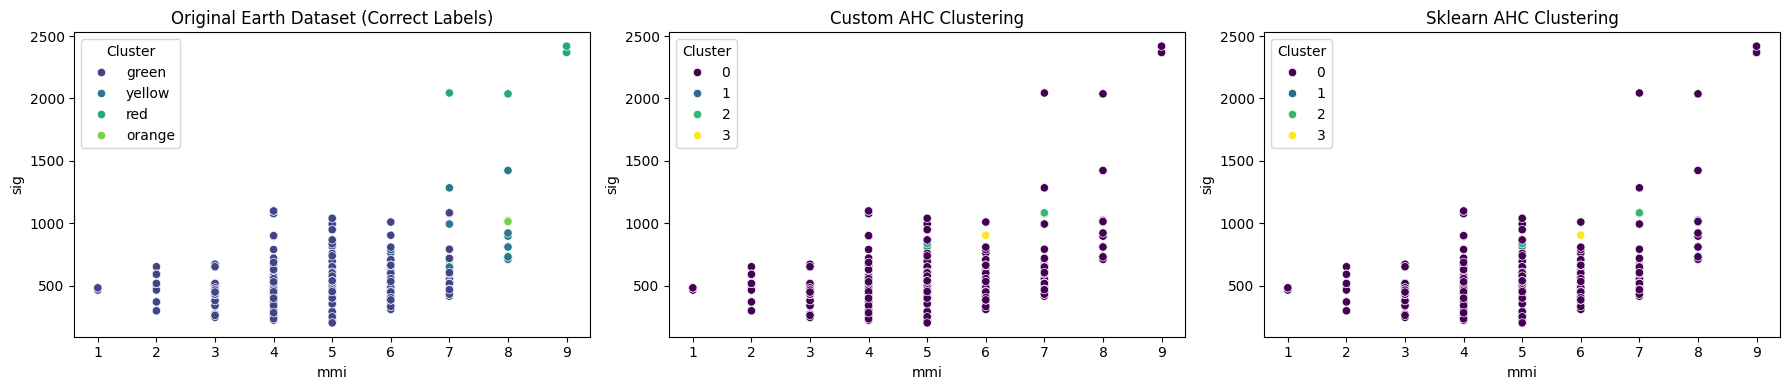

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=earthquakes, x="mmi", y="sig", hue="alert", palette="viridis", ax=axes[0])
axes[0].set_title("Original Earth Dataset (Correct Labels)")
axes[0].set_xlabel("mmi")
axes[0].set_ylabel("sig")
axes[0].legend(title="Cluster")

# Plot 2: Custom AHC Labels (labels_base_ai)
sns.scatterplot(data=earthquakes, x="mmi", y="sig", hue=labels_base_earth, palette="viridis", ax=axes[1])
axes[1].set_title("Custom AHC Clustering")
axes[1].set_xlabel("mmi")
axes[1].set_ylabel("sig")
axes[1].legend(title="Cluster")

# Plot 3: Sklearn AHC Labels (labels_sklearn_ai)
sns.scatterplot(data=earthquakes, x="mmi", y="sig", hue=labels_sklearn_earth, palette="viridis", ax=axes[2])
axes[2].set_title("Sklearn AHC Clustering")
axes[2].set_xlabel("mmi")
axes[2].set_ylabel("sig")
axes[2].legend(title="Cluster")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## Q4 answer

In [33]:
EARTHQUACKE_N_CLUSTERS = 4
from sklearn.feature_selection import SelectKBest, mutual_info_classif

encoder = OrdinalEncoder()

alert_encoded = encoder.fit_transform(earthquakes["alert"].to_frame())
selector = SelectKBest(score_func=mutual_info_classif, k=5)

X_earth = selector.fit_transform(earthquakes_filtered, alert_encoded.ravel())
k_earth = 4

print(f"Global Earthquake Data, Number of data points: {X_earth.shape[0]}, Number of features: {X_earth.shape[1]}")
print("####################### Base AHC #######################")
start_time = time.time()
labels_base_earth = base_ahc(X_earth, EARTHQUACKE_N_CLUSTERS, linkage, distance)

print(f"Execution time (base): {time.time() - start_time} seconds")
print_metrics(X_earth, earthquakes['alert'], labels_base_earth)
#print(labels_base_earth)
print('############################ sklearn AHC #######################')
sklearn_ahc = AgglomerativeClustering(n_clusters=EARTHQUACKE_N_CLUSTERS, linkage=linkage, metric='euclidean')
start_time = time.time()
labels_sklearn_earth = sklearn_ahc.fit_predict(X_earth)

print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
print_metrics(X_earth, earthquakes['alert'], labels_sklearn_earth)
#print(labels_sklearn_earth)

Global Earthquake Data, Number of data points: 764, Number of features: 5
####################### Base AHC #######################
Execution time (base): 79.47066974639893 seconds
-------------------------------------------------------------------
Silhouette score: 0.7333
Adjusted Rand score: 0.3447
Calinski-Harabasz score: 290.0444
Davies-Bouldin score: 0.2085
Mutual Information score: 0.0759
############################ sklearn AHC #######################

Execution time (sklearn): 0.005033016204833984 seconds
-------------------------------------------------------------------
Silhouette score: 0.7333
Adjusted Rand score: 0.3447
Calinski-Harabasz score: 290.0444
Davies-Bouldin score: 0.2085
Mutual Information score: 0.0759


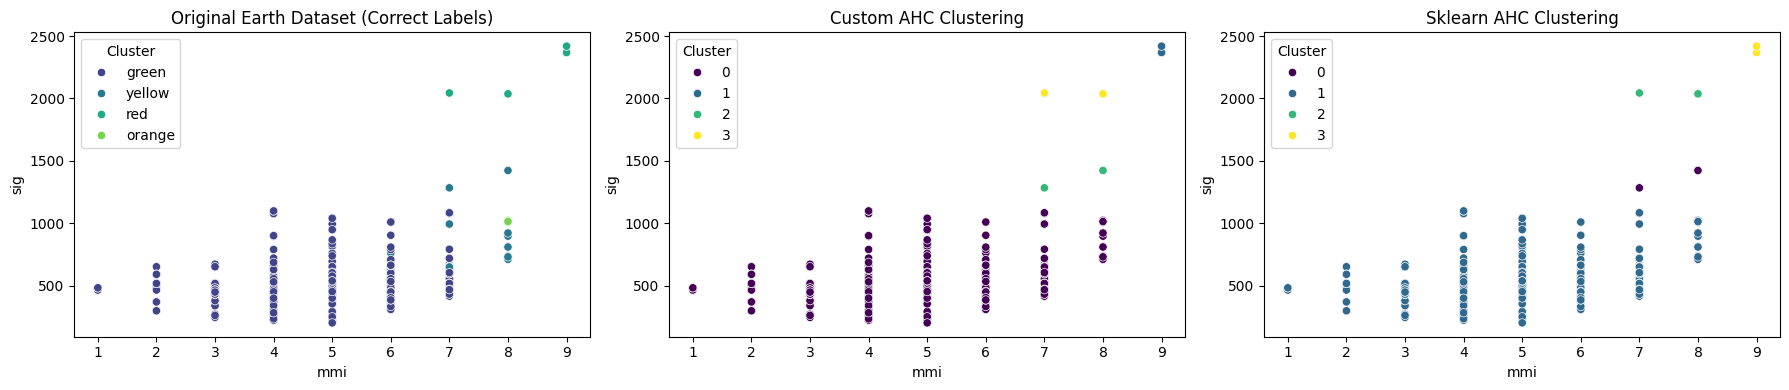

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=earthquakes, x="mmi", y="sig", hue="alert", palette="viridis", ax=axes[0])
axes[0].set_title("Original Earth Dataset (Correct Labels)")
axes[0].set_xlabel("mmi")
axes[0].set_ylabel("sig")
axes[0].legend(title="Cluster")

# Plot 2: Custom AHC Labels (labels_base_ai)
sns.scatterplot(data=earthquakes, x="mmi", y="sig", hue=labels_base_earth, palette="viridis", ax=axes[1])
axes[1].set_title("Custom AHC Clustering")
axes[1].set_xlabel("mmi")
axes[1].set_ylabel("sig")
axes[1].legend(title="Cluster")

# Plot 3: Sklearn AHC Labels (labels_sklearn_ai)
sns.scatterplot(data=earthquakes, x="mmi", y="sig", hue=labels_sklearn_earth, palette="viridis", ax=axes[2])
axes[2].set_title("Sklearn AHC Clustering")
axes[2].set_xlabel("mmi")
axes[2].set_ylabel("sig")
axes[2].legend(title="Cluster")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Generating a comprehensive figure


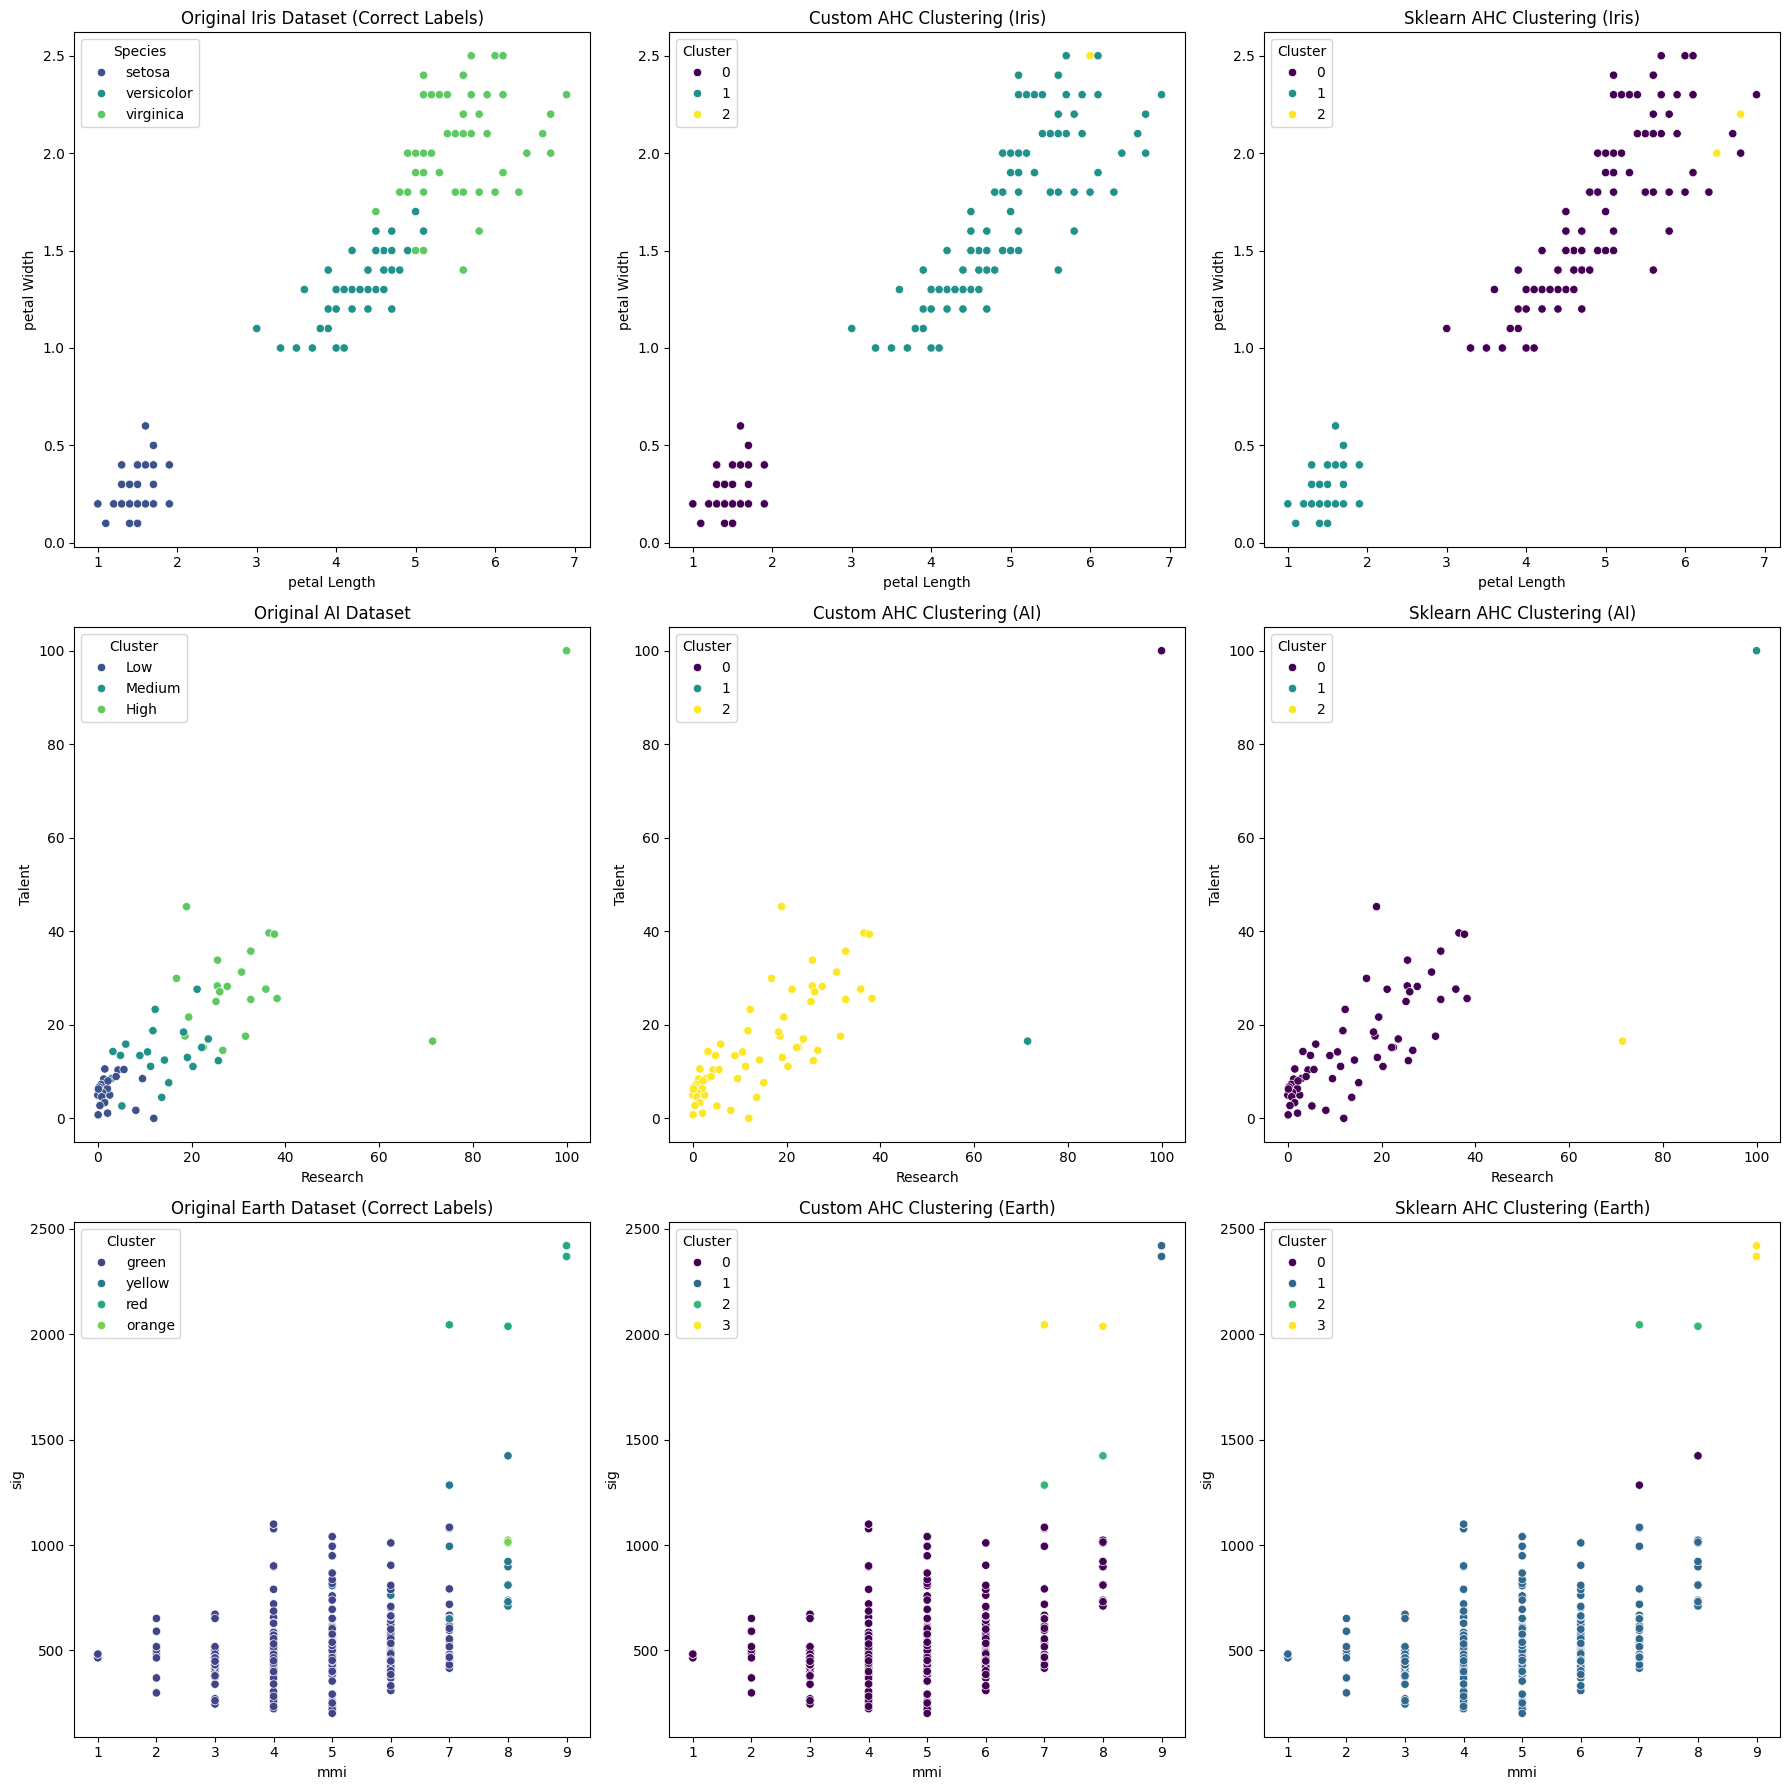

In [35]:
clusters_colors = "viridis"
fig, axes = plt.subplots(3, 3, figsize=(18, 18))  # 3 rows, 3 columns

# Row 1: Iris Dataset
sns.scatterplot(data=iris, x="petal_length", y="petal_width", hue="species", palette=clusters_colors, ax=axes[0][0])
axes[0][0].set_title("Original Iris Dataset (Correct Labels)")
axes[0][0].set_xlabel("petal Length")
axes[0][0].set_ylabel("petal Width")
axes[0][0].legend(title="Species")

sns.scatterplot(data=iris, x="petal_length", y="petal_width", hue=labels_base_iris, palette=clusters_colors, ax=axes[0][1])
axes[0][1].set_title("Custom AHC Clustering (Iris)")
axes[0][1].set_xlabel("petal Length")
axes[0][1].set_ylabel("petal Width")
axes[0][1].legend(title="Cluster")

sns.scatterplot(data=iris, x="petal_length", y="petal_width", hue=labels_sklearn_iris, palette=clusters_colors, ax=axes[0][2])
axes[0][2].set_title("Sklearn AHC Clustering (Iris)")
axes[0][2].set_xlabel("petal Length")
axes[0][2].set_ylabel("petal Width")
axes[0][2].legend(title="Cluster")

# Row 2: AI Dataset
sns.scatterplot(data=ai, x="Research", y="Talent", hue="Total_score_Category", palette=clusters_colors, ax=axes[1][0])
axes[1][0].set_title("Original AI Dataset")
axes[1][0].set_xlabel("Research")
axes[1][0].set_ylabel("Talent")
axes[1][0].legend(title="Cluster")

sns.scatterplot(data=ai, x="Research", y="Talent", hue=labels_base_ai, palette=clusters_colors, ax=axes[1][1])
axes[1][1].set_title("Custom AHC Clustering (AI)")
axes[1][1].set_xlabel("Research")
axes[1][1].set_ylabel("Talent")
axes[1][1].legend(title="Cluster")

sns.scatterplot(data=ai, x="Research", y="Talent", hue=labels_sklearn_ai, palette=clusters_colors, ax=axes[1][2])
axes[1][2].set_title("Sklearn AHC Clustering (AI)")
axes[1][2].set_xlabel("Research")
axes[1][2].set_ylabel("Talent")
axes[1][2].legend(title="Cluster")

# Row 3: Earthquake Dataset
sns.scatterplot(data=earthquakes, x="mmi", y="sig", hue="alert", palette=clusters_colors, ax=axes[2][0])
axes[2][0].set_title("Original Earth Dataset (Correct Labels)")
axes[2][0].set_xlabel("mmi")
axes[2][0].set_ylabel("sig")
axes[2][0].legend(title="Cluster")

sns.scatterplot(data=earthquakes, x="mmi", y="sig", hue=labels_base_earth, palette=clusters_colors, ax=axes[2][1])
axes[2][1].set_title("Custom AHC Clustering (Earth)")
axes[2][1].set_xlabel("mmi")
axes[2][1].set_ylabel("sig")
axes[2][1].legend(title="Cluster")

sns.scatterplot(data=earthquakes, x="mmi", y="sig", hue=labels_sklearn_earth, palette=clusters_colors, ax=axes[2][2])
axes[2][2].set_title("Sklearn AHC Clustering (Earth)")
axes[2][2].set_xlabel("mmi")
axes[2][2].set_ylabel("sig")
axes[2][2].legend(title="Cluster")

plt.tight_layout()
plt.show()
